In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
os.chdir("/sfs/qumulo/qhome/jtb3sud/PARCv2")

import PARC.data.data_meta_learning as data
from PARC.model import model_meta_learning as model


2024-05-08 17:56:03.360464: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-08 17:56:10.031295: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46586 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6


# Data pipeline

In [2]:
# Get data and normalization
state_seq_whole, vel_seq_whole = data.clip_raw_data(sequence_length = 52, n_state_var = 3, purpose = "diff_training", folder_path = '/scratch/jtb3sud/meta_data/tnt/training', image_size = (128, 208))
state_seq_norm = data.data_normalization(state_seq_whole,3)
vel_seq_norm = data.data_normalization(vel_seq_whole,2)

Processing 183118.npy
Processing 183135.npy
Processing 183127.npy
Processing 183134.npy
Processing 183115.npy
Processing 183132.npy
Processing 183114.npy
Processing 183123.npy
Processing 183140.npy
Processing 183130.npy
Processing 183133.npy
Processing 183129.npy
Processing 183111.npy
Processing 183105.npy
Processing 183102.npy
Processing 183113.npy
Processing 183137.npy
Processing 183136.npy
Processing 183119.npy
Processing 183144.npy
Processing 183110.npy
Processing 183112.npy
Processing 183122.npy
Processing 183104.npy
Processing 183128.npy
Processing 183141.npy
Processing 183145.npy
Processing 183103.npy
Processing 183107.npy
Processing 183106.npy
Processing 183121.npy
Processing 183108.npy
Processing 183142.npy
Processing 183109.npy
Processing 183125.npy


# Validation

In [3]:
state_seq_whole, vel_seq_whole = data.clip_raw_data(sequence_length = 52, n_state_var = 3, purpose = "test", folder_path = '/scratch/jtb3sud/meta_data/tnt/testing', image_size = (128, 208))
state_seq_norm_test = data.data_normalization_test(state_seq_whole, state_seq_norm[1], state_seq_norm[2],3)
vel_seq_norm_test = data.data_normalization_test(vel_seq_whole, vel_seq_norm[1], vel_seq_norm[2],2)

Processing 183139.npy
Processing 183131.npy
Processing 183117.npy
Processing 183138.npy
Processing 183116.npy
Processing 183143.npy


## Load model

In [5]:
tf.keras.backend.clear_session()
parc_rk = model.PARCv2(n_state_var = 3, n_time_step = 52, step_size= 1/52, solver = "rk4", image_size = (128, 208))
parc_rk.compile()
parc_rk.differentiator.load_weights('/sfs/qumulo/qhome/jtb3sud/PARCv2/Pretrained_Weights/em/parc2_diff_rk4.h5')
parc_rk.integrator.load_weights('/sfs/qumulo/qhome/jtb3sud/PARCv2/Pretrained_Weights/em/parc2_int_rk4.h5')

In [13]:
state_rk = []
outlier = []
# Loop through the test samples 
for idx in range(6):
    if idx not in outlier:
        print(idx)
        #print(state_seq_norm_test)
        # what is the index helping with
        # why slice with these values?
        
        ## overall a data explanation is crucial for other users to have this 
        ## why must this equal 5 on the end? this should be explained
        ## this is to avoid duplication the state has T, P, mu
        ## velocity holds X, Y
        state_var_current = state_seq_norm_test[idx:idx+1,:,:,0:3]
        velocity_current = vel_seq_norm_test[idx:idx +1,:,:,0:2]
        # Print shapes for debugging
        print("State shape:", state_var_current.shape)
        print("Velocity shape:", velocity_current.shape)
        ## detail what is being input here 
        pred_state = parc_rk.predict([state_var_current,velocity_current])
        pred_state_case = np.concatenate(pred_state, axis = -1)
        print(pred_state_case.shape)
        state_rk.append(pred_state_case)
state_rk = np.concatenate(state_rk, axis = 0)
print(state_rk.shape)       

0
State shape: (1, 128, 208, 3)
Velocity shape: (1, 128, 208, 2)
1/1 [==============================] - 5s 5s/step
(1, 128, 208, 260)
1
State shape: (1, 128, 208, 3)
Velocity shape: (1, 128, 208, 2)
1/1 [==============================] - 5s 5s/step
(1, 128, 208, 260)
2
State shape: (1, 128, 208, 3)
Velocity shape: (1, 128, 208, 2)
1/1 [==============================] - 5s 5s/step
(1, 128, 208, 260)
3
State shape: (1, 128, 208, 3)
Velocity shape: (1, 128, 208, 2)
1/1 [==============================] - 5s 5s/step
(1, 128, 208, 260)
4
State shape: (1, 128, 208, 3)
Velocity shape: (1, 128, 208, 2)
1/1 [==============================] - 5s 5s/step
(1, 128, 208, 260)
5
State shape: (1, 128, 208, 3)
Velocity shape: (1, 128, 208, 2)
1/1 [==============================] - 5s 5s/step
(1, 128, 208, 260)
(6, 128, 208, 260)


In [14]:
import matplotlib.pyplot as plt
from PIL import Image

# Initialize list to store frames
frames = []

for i in range(52):
    # Plot the image
    plt.imshow(state_rk[5, :, :, i * 5], vmin=0, vmax=1, cmap='jet')
    plt.axis('off')  # Turn off axis

    # Convert the figure to a PIL image
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Remove whitespace
    fig = plt.gcf()
    fig.canvas.draw()
    pil_image = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())

    # Close the plot to prevent display
    plt.close()

    # Append the PIL image to the frames list
    frames.append(pil_image)

# Save frames as a GIF
frames[0].save('state_rk_animation.gif', save_all=True, append_images=frames[1:], duration=100, loop=0)


/tmp/ipykernel_513489/1193845092.py:16: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  pil_image = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())


In [15]:
import PARC.visualization.visualization_em as viz
## visualization needs to be explained

In [16]:
# Denormalizing prediction data
pred_out = data.data_denormalization(state_rk,state_seq_norm[1] + vel_seq_norm[1],state_seq_norm[2] + vel_seq_norm[2], no_of_channel = 5)

In [17]:
# Save results file for plotting
np.save('/scratch/jtb3sud/results/tnt',pred_out)

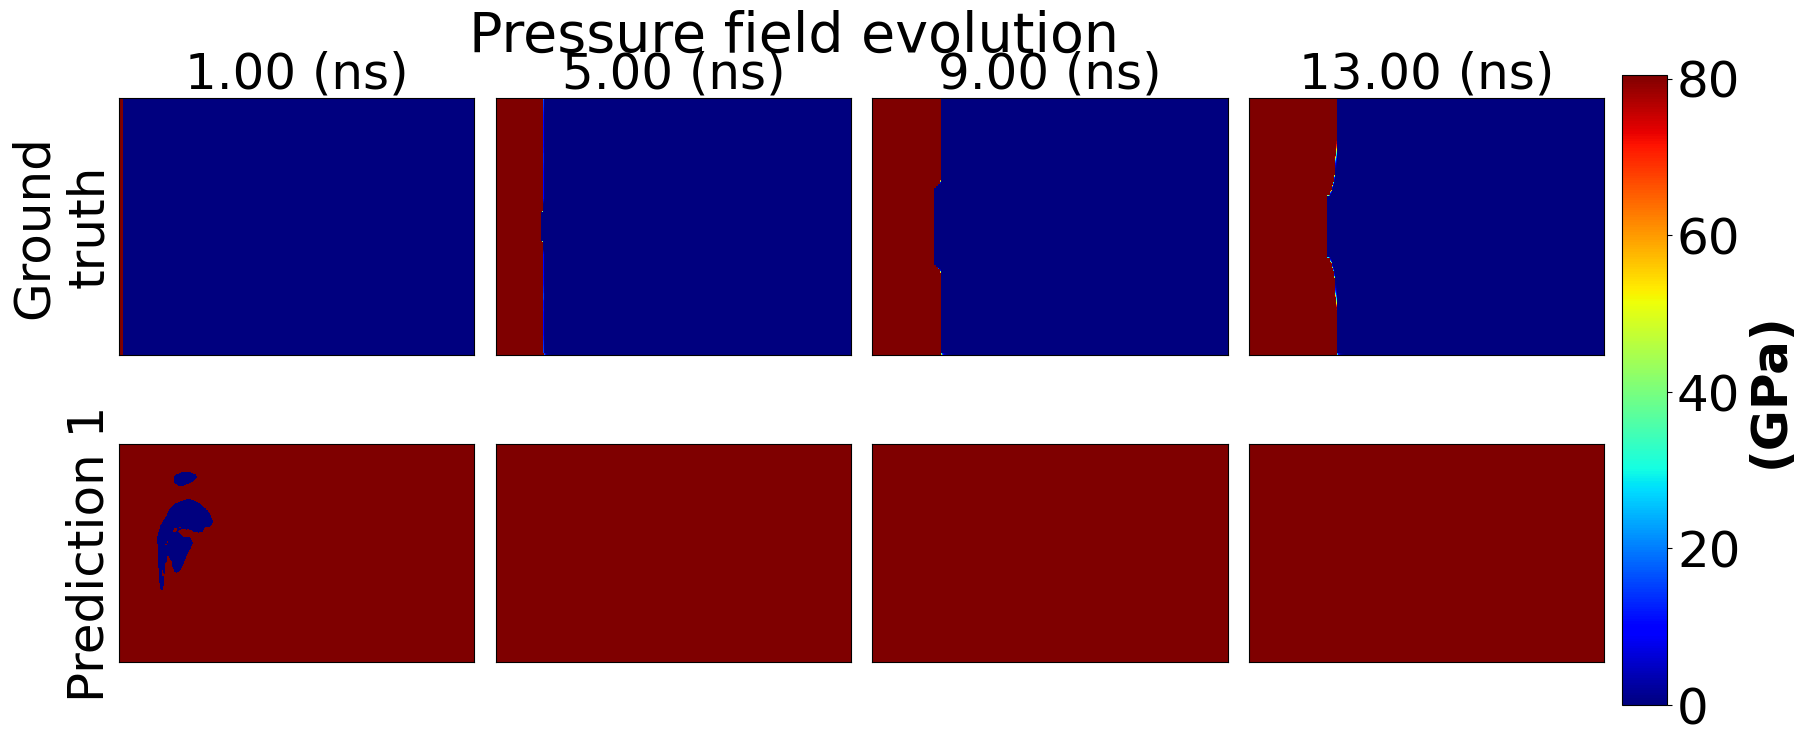

In [21]:
import numpy as np
gt = np.load('/scratch/jtb3sud/results/gt.npy')
#y_pred = [parcv2, parc, parc_data_int[:,:,:,:-5], fno]
y_pred = [pred_out]
viz.plot_field_evolution(y_pred, gt, 5, 'pressure', 208)